In [26]:
import numpy as np

import pandas as pd

import xarray as xr

from affine import Affine

import matplotlib.pyplot as plt

import rasterio 

from rasterio.plot import show

from glob import glob

import rioxarray

In [27]:
from scipy import stats
import dask.array as da
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.pyplot as plt 
from statsmodels.graphics.gofplots import qqplot_2samples


In [28]:
# start a Dask client
from dask.distributed import Client

client = Client()
client


C:\Users\qijue.chen\AppData\Local\anaconda3\lib\site-packages\distributed\node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55850 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:55850/status,
Dashboard: http://127.0.0.1:55850/status,Workers: 4
Total threads: 12,Total memory: 31.72 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55851,Workers: 4
Dashboard: http://127.0.0.1:55850/status,Total threads: 12
Started: Just now,Total memory: 31.72 GiB
Comm: tcp://127.0.0.1:55883,Total threads: 3
Dashboard: http://127.0.0.1:55884/status,Memory: 7.93 GiB
Nanny: tcp://127.0.0.1:55856,


In [29]:

da1 = rasterio.open(r"C:\Users\qijue.chen\Downloads\2D_model_output_sample_data\2D_model_output_sample_data\terrain\Terrain_Addison_M03.tif",masked=True)
#transform = Affine.from_gdal(*da.attrs['transform']) # this is important to retain the geographic attributes from the file
da1

<open DatasetReader name='C:/Users/qijue.chen/Downloads/2D_model_output_sample_data/2D_model_output_sample_data/terrain/Terrain_Addison_M03.tif' mode='r'>

In [30]:
da1.read_masks(1)

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

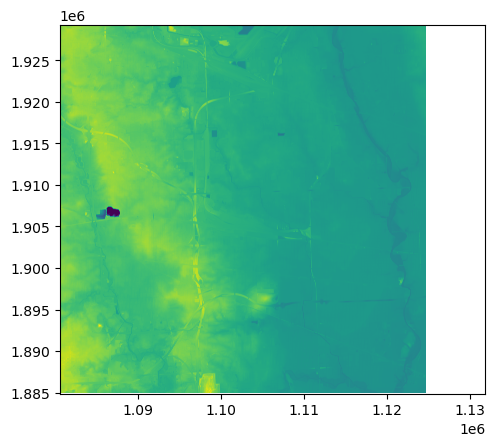

<Axes: >

In [31]:
show(da1)

In [32]:
da1 = xr.open_rasterio(r"C:\Users\qijue.chen\Downloads\2D_model_output_sample_data\2D_model_output_sample_data\wsel_grids\WSE_Addison_M03_H04_E4001.tif")
transform = Affine.from_gdal(*da1.attrs['transform']) # this is important to retain the geographic attributes from the file
print(da1)

<xarray.DataArray (band: 1, y: 8899, x: 10249)>
[91205851 values with dtype=float32]
Coordinates:
  * band     (band) int32 1
  * y        (y) float64 1.929e+06 1.929e+06 1.929e+06 ... 1.885e+06 1.885e+06
  * x        (x) float64 1.081e+06 1.081e+06 1.081e+06 ... 1.132e+06 1.132e+06
Attributes:
    transform:                 (5.0, 0.0, 1080548.6459105245, 0.0, -5.0, 1929...
    crs:                       +init=epsg:3435
    res:                       (5.0, 5.0)
    is_tiled:                  1
    nodatavals:                (-9999.0,)
    scales:                    (1.0,)
    offsets:                   (0.0,)
    AREA_OR_POINT:             Area
    HISTOGRAM:                 706|65|79|98|144|70|55|300|37|40|42|42|69|84|8...
    TIFFTAG_ARTIST:            HEC-RAS
    TIFFTAG_IMAGEDESCRIPTION:  WSE (Max)


C:\Users\qijue.chen\AppData\Local\Temp\ipykernel_17048\936586548.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  da1 = xr.open_rasterio(r"C:\Users\qijue.chen\Downloads\2D_model_output_sample_data\2D_model_output_sample_data\wsel_grids\WSE_Addison_M03_H04_E4001.tif")


In [33]:
da1_ = np.ma.masked_array(da1, da1 == -9999.0)

In [34]:
# ds = xr.DataArray.to_dataset(da1, name = "wse dataset")
# ds['band']
band = xr.DataArray.to_numpy(da1)
print(band)

[[[-9999. -9999. -9999. ... -9999. -9999. -9999.]
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]
  ...
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]
  [-9999. -9999. -9999. ... -9999. -9999. -9999.]]]


In [35]:
print(da1['band'])

<xarray.DataArray 'band' (band: 1)>
array([1])
Coordinates:
  * band     (band) int32 1


In [36]:
#exceedance_p = np.array([0.5, 0.8, 0.9, 0.95, 0.98, 0.99])
exceedance_p = 0.5

def weibull_fit(data, exceed_p):
    if (data==-9999.0).any():
        return (np.nan)
    ranks = (data).argsort().argsort()+1
    probs = ranks/(len(ranks)+1)
    slope, intercept = np.polyfit(probs, np.log10(data), 1)
    level = 10**(slope*exceed_p+intercept)
    return level#, levels

# da_fit = np.apply_along_axis(weibull_fit, 1, band, exceedance_p)
# da_fit

In [37]:
#res = xr.apply_ufunc(weibull_fit, da1, input_core_dims=[["band"]], kwargs={'exceed_p': exceedance_p}, dask = 'allowed', vectorize = True)

In [38]:
print(type(da1))
print("the minimum raster value is: ", np.nanmin(da1.values))
print("the maximum raster value is: ", np.nanmax(da1.values))

<class 'xarray.core.dataarray.DataArray'>
the minimum raster value is:  -9999.0
the maximum raster value is:  673.82513


In [39]:
# Path of the folder containing the .tiff files
IMG_PATH = 'C:/Users/qijue.chen/Downloads/2D_model_output_sample_data/2D_model_output_sample_data/wsel_grids/'

# List of .tiff files
sentinel_bands = glob(f"{IMG_PATH}*.tif")
sentinel_bands.sort() # sorted list
        
ls_bands = [] # list filled with the first layer of each file
for band in sentinel_bands:
    with xr.open_rasterio(band) as b:
        ls_bands.append(b[0,]) # index 0 corresponds to the first band of each file

# Stack bands into a single DataArray
sentinel_bands

# change the lib to rioxarray-rasterio
# chunk parameter 128*128


C:\Users\qijue.chen\AppData\Local\Temp\ipykernel_17048\424102387.py:10: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  with xr.open_rasterio(band) as b:


['C:/Users/qijue.chen/Downloads/2D_model_output_sample_data/2D_model_output_sample_data/wsel_grids\\WSE_Addison_M03_H04_E4001.tif',
 'C:/Users/qijue.chen/Downloads/2D_model_output_sample_data/2D_model_output_sample_data/wsel_grids\\WSE_Addison_M03_H04_E4002.tif',
 'C:/Users/qijue.chen/Downloads/2D_model_output_sample_data/2D_model_output_sample_data/wsel_grids\\WSE_Addison_M03_H04_E4003.tif',
 'C:/Users/qijue.chen/Downloads/2D_model_output_sample_data/2D_model_output_sample_data/wsel_grids\\WSE_Addison_M03_H04_E4004.tif',
 'C:/Users/qijue.chen/Downloads/2D_model_output_sample_data/2D_model_output_sample_data/wsel_grids\\WSE_Addison_M03_H04_E4005.tif',
 'C:/Users/qijue.chen/Downloads/2D_model_output_sample_data/2D_model_output_sample_data/wsel_grids\\WSE_Addison_M03_H04_E4006.tif',
 'C:/Users/qijue.chen/Downloads/2D_model_output_sample_data/2D_model_output_sample_data/wsel_grids\\WSE_Addison_M03_H04_E4007.tif',
 'C:/Users/qijue.chen/Downloads/2D_model_output_sample_data/2D_model_output_

In [40]:
# Path of the folder containing the .tiff files
IMG_PATH = 'C:/Users/qijue.chen/Downloads/2D_model_output_sample_data/2D_model_output_sample_data/wsel_grids/'

# List of .tiff files
sentinel_bands = glob(f"{IMG_PATH}*.tif")
sentinel_bands.sort() # sorted list
        
ls_bands = [] # list filled with the first layer of each file
for band in sentinel_bands:
    xds = rioxarray.open_rasterio(band, chunks = (128,128))
    ls_bands.append(xds) # index 0 corresponds to the first band of each file

# Stack bands into a single DataArray
print(type(ls_bands[0]))

# change the lib to rioxarray-rasterio
# chunk parameter 128*128


<class 'xarray.core.dataarray.DataArray'>


In [41]:
print(type(ls_bands[0]))
print(len(ls_bands))

<class 'xarray.core.dataarray.DataArray'>
96


In [42]:
#final = np.asarray(ls_bands) # shape = (60000,28,28)

In [43]:
ds = ls_bands[0].to_dataset(name = "wse1")

idx = 1
for i in range(idx,len(ls_bands)):
    var_name = "wse"+ str(i+1)
    ds[var_name] = ls_bands[i]
    
ds


<xarray.Dataset>
Dimensions:      (band: 1, x: 10249, y: 8899)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 1.081e+06 1.081e+06 ... 1.132e+06 1.132e+06
  * y            (y) float64 1.929e+06 1.929e+06 ... 1.885e+06 1.885e+06
    spatial_ref  int32 0
Data variables: (12/96)
    wse1         (band, y, x) float32 dask.array<chunksize=(1, 128, 10249), meta=np.ndarray>
    wse2         (band, y, x) float32 dask.array<chunksize=(1, 128, 10249), meta=np.ndarray>
    wse3         (band, y, x) float32 dask.array<chunksize=(1, 128, 10249), meta=np.ndarray>
    wse4         (band, y, x) float32 dask.array<chunksize=(1, 128, 10249), meta=np.ndarray>
    wse5         (band, y, x) float32 dask.array<chunksize=(1, 128, 10249), meta=np.ndarray>
    wse6         (band, y, x) float32 dask.array<chunksize=(1, 128, 10249), meta=np.ndarray>
    ...           ...
    wse91        (band, y, x) float32 dask.array<chunksize=(1, 128, 10249), meta=np.ndarray>
    wse92        (band, y, x) float32 dask.array<chunksize=(1, 128, 10249), meta=np.ndarray>
    wse93        (band, y, x) float32 dask.array<chunksize=(1, 128, 10249), meta=np.ndarray>
    wse94        (band, y, x) float32 dask.array<chunksize=(1, 128, 10249), meta=np.ndarray>
    wse95        (band, y, x) float32 dask.array<chunksize=(1, 128, 10249), meta=np.ndarray>
    wse96        (band, y, x) float32 dask.array<chunksize=(1, 128, 10249), meta=np.ndarray>

In [44]:

index_list = range(1, 97)
# ds.to_array("scenario", name="all_images").to_dataset().assign_coords(
#     scenario=index_list
# )

ds = xr.concat(
    [ds[f"wse{i}"] for i in range(1, len(index_list) + 1)],
    dim=pd.Index(index_list, name="scenario"),
).to_dataset(name="all_runs")


#     xr.concat([da.isel(x=0), da.isel(x=1)], "new_dim")

In [45]:
ds['all_runs']

,Array,Chunk
Bytes,32.62 GiB,5.00 MiB
Shape,"(96, 1, 8899, 10249)","(1, 1, 128, 10249)"
Count,20256 Tasks,6720 Chunks
Type,float32,numpy.ndarray


In [59]:
exceedance_p = np.array([0.9, 0.99])

def weibull_fit(data: np.ndarray, exceed_p):
    if np.isnan(data).any():
        return (np.nan, np.nan)
    ranks = (data).argsort().argsort()+1
    probs = ranks/(len(ranks)+1)
    slope, intercept = np.polyfit(probs, np.log10(data), 1)
    #levels = 10**(slope*exceed_p+intercept)
    return slope, intercept#, levels

da_fit = da.apply_along_axis(weibull_fit, 0,  ds['all_runs'], exceedance_p)
da_fit


C:\Users\qijue.chen\AppData\Local\anaconda3\lib\site-packages\dask\array\routines.py:508: RankWarning: Polyfit may be poorly conditioned
  test_result = np.array(func1d(test_data, *args, **kwargs))


,Array,Chunk
Bytes,1.36 GiB,20.02 MiB
Shape,"(2, 1, 8899, 10249)","(2, 1, 128, 10249)"
Count,20396 Tasks,70 Chunks
Type,float64,numpy.ndarray


In [60]:
def weibull_quantiles(params, exceed_p):
    slope = params[0]
    intercept = params[1]
    if all(params):
        return 10**(slope*exceed_p+intercept)
    bad_result = np.empty((len(probs),))
    bad_result[:] = np.nan
    return bad_result
    
da_quantiles = da.apply_along_axis(weibull_quantiles, 0, da_fit, exceedance_p, shape=(len(exceedance_p),), dtype=float)
da_quantiles

,Array,Chunk
Bytes,1.36 GiB,20.02 MiB
Shape,"(2, 1, 8899, 10249)","(2, 1, 128, 10249)"
Count,20466 Tasks,70 Chunks
Type,float64,numpy.ndarray


In [61]:
da_meta = da.concatenate([da_fit, da_quantiles], axis=0)
da_meta

,Array,Chunk
Bytes,2.72 GiB,20.02 MiB
Shape,"(4, 1, 8899, 10249)","(2, 1, 128, 10249)"
Count,20606 Tasks,140 Chunks
Type,float64,numpy.ndarray


In [75]:
da_meta_slice = da_meta[0, :, :]

In [74]:
import imageio
imageio.mimwrite("image.tiff", da_meta_slice)

LinAlgError: SVD did not converge in Linear Least Squares

In [66]:
# Convert the "fit" DataArray into a DataFrame
meta_cols = ['slope', 'intercept', '10yr', '100yr']
df_meta = dd.io.from_dask_array(da_meta, columns=meta_cols)
df_meta

ValueError: from_array does not input more than 2D array, got array with shape (4, 1, 8899, 10249)

In [56]:
print(type(da_fit))
print(da_fit)

<class 'dask.array.core.Array'>
dask.array<weibull_fit-along-axis, shape=(2, 1, 8899, 10249), dtype=float64, chunksize=(2, 1, 128, 10249), chunktype=numpy.ndarray>


In [51]:
def save_file(arr, block_info=None):
    """ Save file to foo-x-y.tif, where x and y are block locations """
    filename = "foo-" + "-".join(map(str, block_info[0]["chunk-location"])) + ".tif"
    skimage.io.imsave(filename, arr)
    return arr

da_fit.map_blocks(save_file, dtype=da_fit.dtype).compute()       # call function on every block

LinAlgError: SVD did not converge in Linear Least Squares